# Tutorial 5: Convergence model

In [1]:
import UWGeodynamics as GEO

loaded rc file /workspace/user_data/UWGeodynamics/UWGeodynamics/uwgeo-data/uwgeodynamicsrc


In [2]:
u = GEO.UnitRegistry

## Scaling

In [3]:
# Characteristic values of the system
half_rate = (0.5 * u.centimeter / u.year).to(u.meter / u.second)
model_length = 192 * u.kilometer
model_height = 40. * u.kilometer
surfaceTemp = 273.15 * u.degK
baseModelTemp = 823.15 * u.degK
bodyforce = (2800 * u.kilogram / u.metre**3 * 9.81 * u.meter / u.second**2)


KL = model_length
Kt = KL / half_rate
KM = bodyforce * KL**2 * Kt**2
KT = (baseModelTemp - surfaceTemp)

GEO.scaling_coefficients["[length]"] = KL
GEO.scaling_coefficients["[time]"] = Kt
GEO.scaling_coefficients["[mass]"]= KM
GEO.scaling_coefficients["[temperature]"] = KT

# Define the external geometry

The first step is to define the geometry of our problem, essentially a box on which we will apply some physical constraints and that will contain a set of materials. We can think of it as an "universe".
The "laws" and their effects are calculated on a mesh, that mesh discretized our universe into finite elements.

The geodynamics module allows you to quickly set up a model by creating a *Model* object.
A series of arguments are required to define a *Model*:

    - The number of elements in each direction elementRes=(nx, ny);
    - The minimum coordinates for each axis minCoord=(minX, minY)
    - The maximum coordinates for each axis maxCoord=(maxX, maxY)
    - A vector that defines the magnitude and direction of the gravity components gravity=(gx, gy)
 

In [4]:
Model = GEO.Model(elementRes=(192, 48), 
                  minCoord=(0. * u.kilometer, -28. * u.kilometer), 
                  maxCoord=(192. * u.kilometer, 20. * u.kilometer), 
                  gravity=(0.0, -9.81 * u.meter / u.second**2))

In [5]:
Model.outputDir="outputs_tutorial5"

# Add some Materials

Now that we have our "universe" (box, sand pit) ready, we need to fill it with some materials.
The *geodynamics* module is designed around that idea of materials, which are essentially a way to define physical properties across the Model domain.

A material (or a phase) is first defined by the space it takes in the box (its shape).

In [6]:
# Air Layer
air = Model.add_material(name="Air", shape=GEO.shapes.Layer(top=Model.top, bottom=0 * u.kilometer))
air.density = 1. * u.kilogram / u.metre**3
air.radiogenicHeatProd = 0.0
air.diffusivity = 1e-6 * u.metre**2 / u.second 
air.capacity = 100. * u.joule / (u.kelvin * u.kilogram)

In [7]:
# Uppercrust Layer
crust = Model.add_material(name="Crust", shape=GEO.shapes.Layer(top=0. * u.kilometer, bottom=Model.bottom))
crust.radiogenicHeatProd = 0.9 * u.microwatt / u.meter**3
crust.density  = GEO.LinearDensity(reference_density=2800. * u.kilogram / u.metre**3, thermalExpansivity=2.5e-5 / u.kelvin)
crust.diffusivity = 1e-6 * u.metre**2 / u.second 
crust.capacity    = 1000. * u.joule / (u.kelvin * u.kilogram)

# Limit the range of viscosities on that specific material
crust.minViscosity = 1e19 * u.pascal * u.second
crust.maxViscosity = 1e23 * u.pascal * u.second


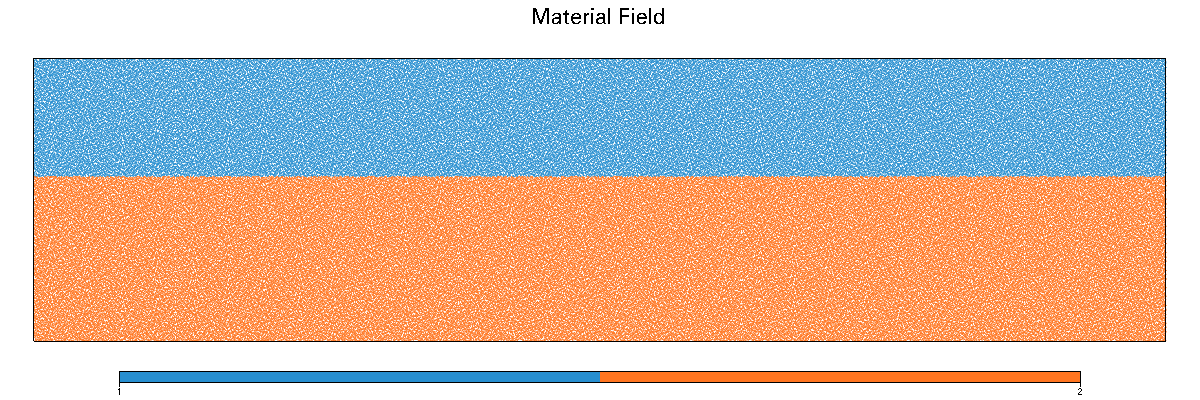

In [8]:
Fig = Model.plot.material(onMesh=False, figsize=(1200,400), fn_size=2.)

## Passive Tracers

In [32]:
import numpy as np

x = np.linspace(Model.minCoord[0], Model.maxCoord[0], 1000) * u.kilometer
y = GEO.nd(crust.top)

surface_tracers = Model.add_passive_tracers(vertices=[x,y])
line1 = Model.add_passive_tracers(vertices=[x,y-5.*u.kilometer])
line2 = Model.add_passive_tracers(vertices=[x,y-10.*u.kilometer])
line3 = Model.add_passive_tracers(vertices=[x,y-15.*u.kilometer])
line4 = Model.add_passive_tracers(vertices=[x,y-20.*u.kilometer])
line5 = Model.add_passive_tracers(vertices=[x,y-25.*u.kilometer])


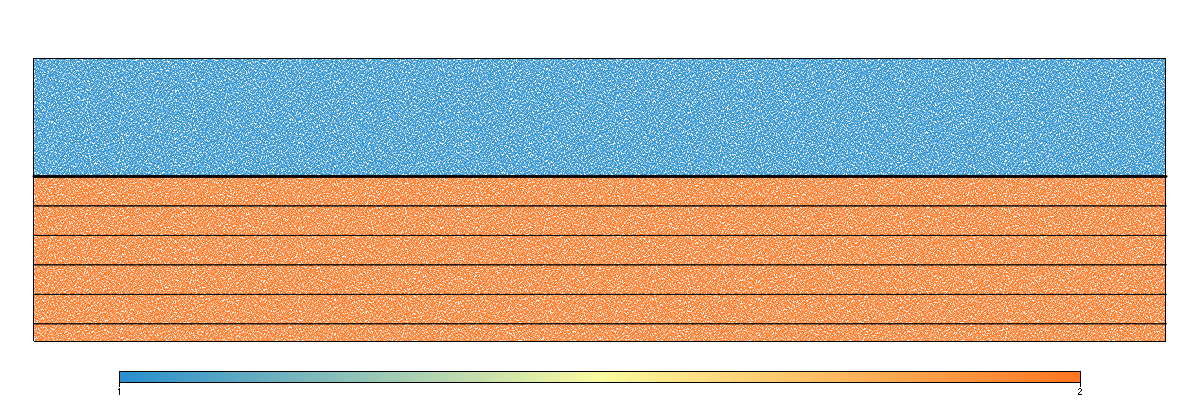

In [34]:
import glucifer
Fig = glucifer.Figure(figsize=(1200,400))
Fig.Points(surface_tracers.swarm, pointSize=4.0)
Fig.Points(line1.swarm, pointSize=2.0)
Fig.Points(line2.swarm, pointSize=2.0)
Fig.Points(line3.swarm, pointSize=2.0)
Fig.Points(line4.swarm, pointSize=2.0)
Fig.Points(line5.swarm, pointSize=2.0)
Fig.Points(Model.swarm, Model.materialField, fn_size=2.0)
Fig.show()

# Define Viscosities

The rheology library contains some commonly used rheologies stored in a python dictionary structure. We can list the keys defining the rheologies as follows:

In [35]:
rh = GEO.ViscousCreepRegistry()

In [36]:
rh.Tullis_et_al_2002

In [37]:
air.viscosity = 1e19 * u.pascal * u.second
crust.viscosity = rh.Tullis_et_al_2002

# Define Plasticity

Plastic behavior is assigned using the same approach as for viscosities.

In [38]:
crust.plasticity = GEO.DruckerPrager(cohesion=20.* u.megapascal, cohesionAfterSoftening=10.*u.megapascal, frictionCoefficient=0.268, frictionAfterSoftening=0.035)

## Temperature Boundary Condition

In [39]:
Model.set_temperatureBCs(top=293.15 * u.degK, 
                         bottom=823.15 * u.degK, 
                         materials=[(air, 293.15 * u.degK )])

## Velocity Boundary Conditions

In [40]:
Model.set_velocityBCs(left=[1.0 * u.centimeter / u.year, None],
                       right=[-1.0 * u.centimeter / u.year, None],
                       bottom=[None, 0.0])

## Initial Damage

In [41]:
import numpy as np

def gaussian(xx, centre, width):
    return ( np.exp( -(xx - centre)**2 / width ))

maxDamage = 0.7
Model.plasticStrain.data[:,0] = maxDamage * np.random.rand(Model.plasticStrain.data.size)
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,0], (GEO.nd(Model.maxCoord[0] - Model.minCoord[0])) / 2.0, GEO.nd(5.0 * u.kilometer))
Model.plasticStrain.data[:,0] *= gaussian(Model.swarm.particleCoordinates.data[:,1], GEO.nd(-14. * u.kilometer) , GEO.nd(0.5 * u.kilometer))


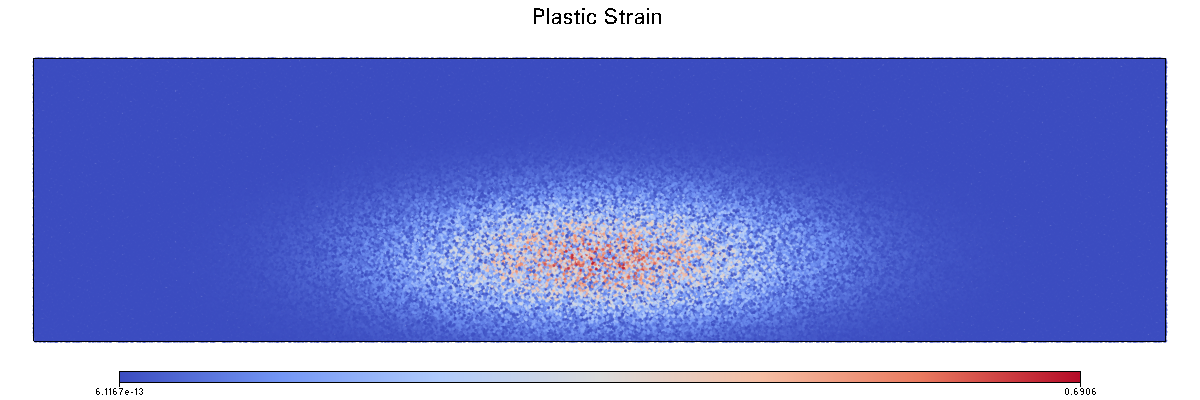

In [18]:
Fig = Model.plot.plastic_strain(onMesh=False, figsize=(1200,400), fn_size=4., colours="coolwarm")

## Run Model

In [19]:
Model.init_model()


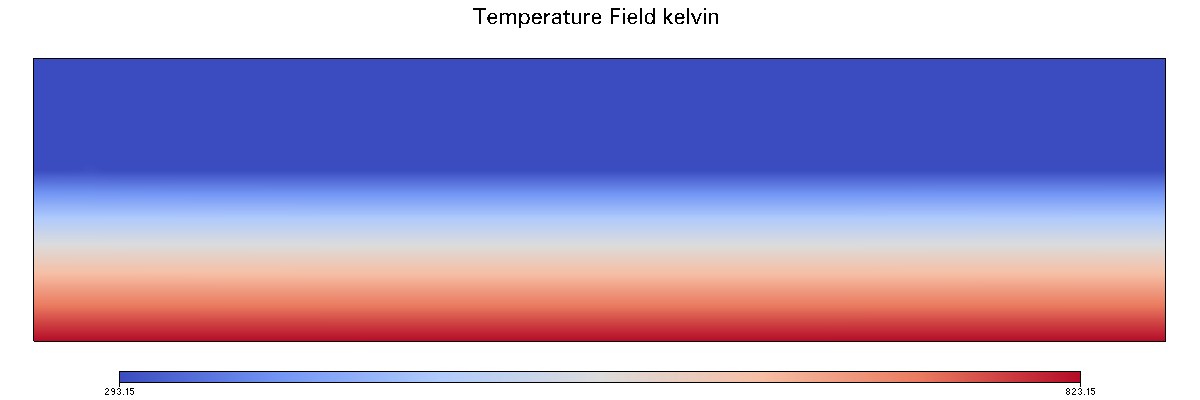

In [20]:
Fig = Model.plot.temperature(figsize=(1200,400))


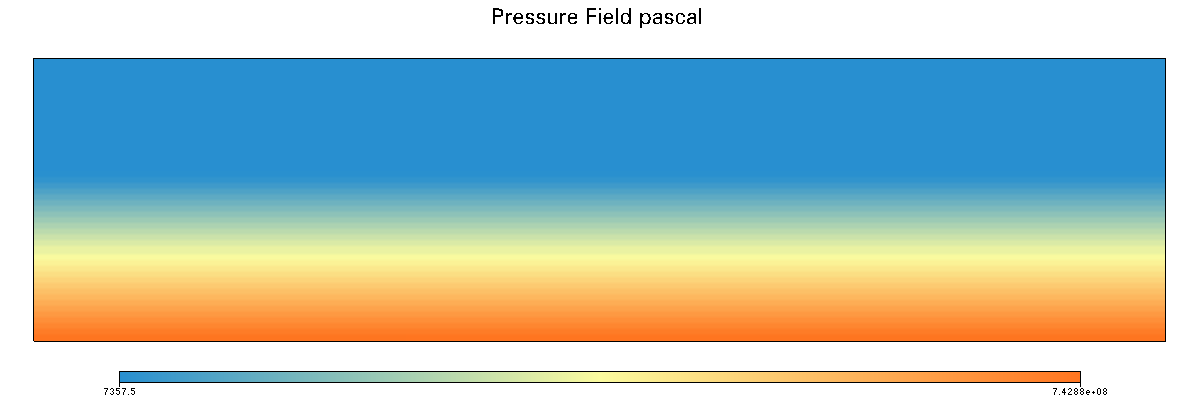

In [21]:
Fig = Model.plot.pressureField(figsize=(1200,400))


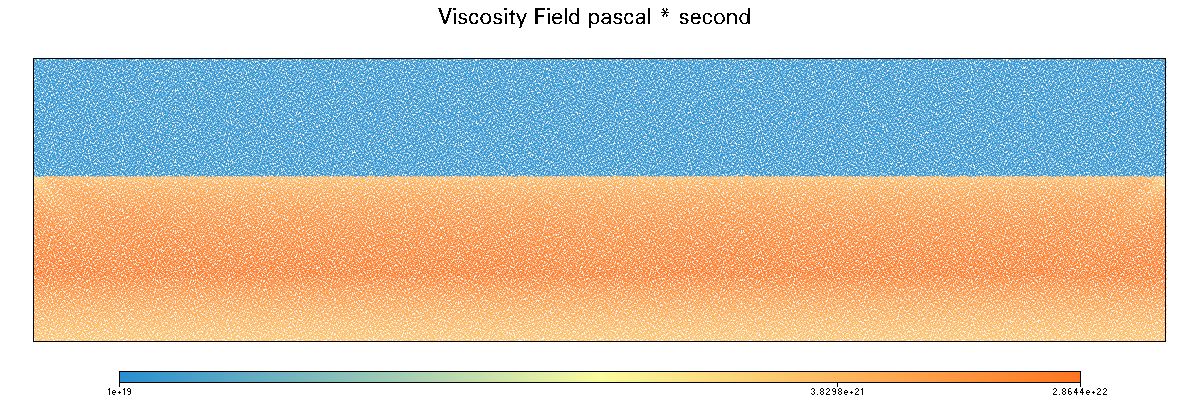

In [27]:
Fig = Model.plot.viscosity(onMesh=False, figsize=(1200,400), fn_size=2.)

In [22]:
Model.run_for(5000.* u.years, dt=2000. * u.years)

Time:  2000.0 year dt: 2000.0 year
Time:  4000.0 year dt: 2000.0 year
Time:  5000.0 year dt: 1000.0 year


1


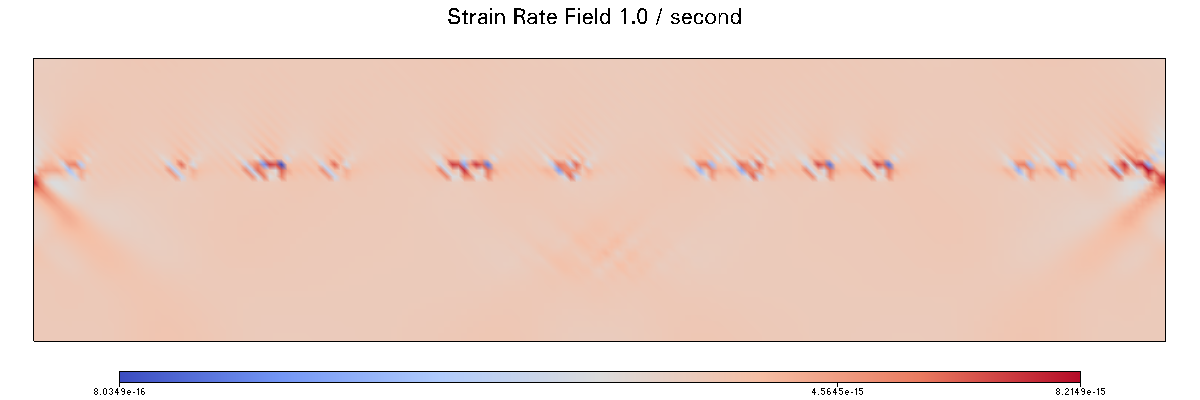

In [28]:
Fig = Model.plot.strainRate(figsize=(1200,400))